In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (이하 이진값 타겟변수에 적용)
## 1. 타겟변수 비율 점검 및 필요시 조치

In [ ]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import graphviz
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/t/dataset-6(14).csv')
df.shape

(82122, 85)

In [ ]:
data = df.drop(['hospital_death'], axis=1)   # 타겟변수를 제외한 변수만 data에 저장
target = df['hospital_death']                # 타겟변수만 target에 저장
data.shape

(82122, 84)

In [ ]:
target.shape

(82122,)

In [ ]:
df['hospital_death'].value_counts(dropna=False)

0    76134
1     5988
Name: hospital_death, dtype: int64

In [ ]:
df['hospital_death'].value_counts(dropna=False, normalize=True)

0    0.927084
1    0.072916
Name: hospital_death, dtype: float64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler    # RandomUnderSampler를 import
undersample = RandomUnderSampler(sampling_strategy=0.333, random_state=2)
                                                          # 타겟변수의 소수 클래스 및 다수 클래스를
                                                          # 1:3의 비율(=1/3)로 언더샘플링
data_under, target_under = undersample.fit_resample(data, target)
                                                          # data 및 target에 언더샘플링 적용

In [ ]:
target_under.value_counts(dropna=True)

0    17981
1     5988
Name: hospital_death, dtype: int64

In [ ]:
target_under.value_counts(dropna=True, normalize=True)

0    0.750177
1    0.249823
Name: hospital_death, dtype: float64

In [ ]:
# 50:50 비율로 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_under, target_under, test_size=0.5, random_state=42, stratify = target_under)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (11984, 84)
X_test shape: (11985, 84)


In [ ]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (11984,)
y_test shape: (11985,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.750167
1    0.249833
Name: hospital_death, dtype: float64

In [ ]:
y_train.value_counts()

0    8990
1    2994
Name: hospital_death, dtype: int64

## 2.트리모델 실행 및 성능평가

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82122 entries, 0 to 82121
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   82122 non-null  int64  
 1   patient_id                     82122 non-null  int64  
 2   hospital_id                    82122 non-null  int64  
 3   age                            82122 non-null  float64
 4   bmi                            82122 non-null  float64
 5   elective_surgery               82122 non-null  int64  
 6   height                         82122 non-null  float64
 7   icu_id                         82122 non-null  int64  
 8   pre_icu_los_days               82122 non-null  float64
 9   weight                         82122 non-null  float64
 10  apache_2_diagnosis             82122 non-null  float64
 11  apache_3j_diagnosis            82122 non-null  float64
 12  apache_post_operative          82122 non-null 

In [ ]:
# Decision Tree 모델 (Default인 GINI기준이자 Maximal depth 조건)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(random_state=0)   # Classifier로 DecisionTreeClassifer 지정
model = tree.fit(X_train, y_train)   # Clssifier를 트레이닝 데이터셋에서 학습시킴
pred = model.predict(X_test)  # 학습된 Classifier로 테스트 데이터셋 자료이용해서 타겟변수 예측값 생성

print("Accuracy(GINI) on training set:{:.5f}".format(model.score(X_train, y_train)))
print("Accuracy(GINI) on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Accuracy(GINI) on training set:1.00000
Accuracy(GINI) on test set:0.75044


In [ ]:
# Decision Tree 모델 (Gini 기준)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(criterion="gini", random_state=0, max_depth=5)

params = {'criterion':['gini','entropy'],'max_depth': range(1,21)}

grid_tree = GridSearchCV(tree, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1,
                     verbose=1)
grid_tree.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_tree.best_score_))
print("GridSearchCV best parameter:", (grid_tree.best_params_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
GridSearchCV max accuracy:0.82343
GridSearchCV best parameter: {'criterion': 'entropy', 'max_depth': 6}


In [ ]:
best_clf = grid_tree.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Accuracy on test set:0.81202


In [ ]:
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

ROC AUC on test set:0.83065


In [ ]:
print ("Feature importances:")
print (best_clf.feature_importances_)

Feature importances:
[0.00699159 0.00168624 0.         0.00977547 0.         0.
 0.00220255 0.00289936 0.00340041 0.00282195 0.00652696 0.03360528
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00925873 0.02338341
 0.         0.00236968 0.00294962 0.         0.00764268 0.00716912
 0.         0.0124151  0.00429744 0.0026279  0.00324128 0.01004119
 0.         0.01354979 0.         0.01282248 0.         0.02093777
 0.0033459  0.00444462 0.         0.         0.         0.
 0.         0.         0.0016541  0.         0.         0.
 0.00123649 0.00165898 0.0023817  0.00482047 0.00372987 0.00295681
 0.         0.00602318 0.         0.00253461 0.00215629 0.00291333
 0.74473796 0.01278969 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [ ]:
# 변수명을 Index로 만들고 feature_importances를 매칭해서 나열한 데이터프레임 만들기

feature_names = list(data.columns)   # 변수명(컬럼명)을 리스트 형태로 만들기
dft = pd.DataFrame(np.round(best_clf.feature_importances_, 4), index=feature_names,
                   columns=['Feature_importances'])
dft1 = dft.sort_values(by='Feature_importances', ascending=False)
dft1                                 # 컬럼 Feature_importances의 값들을 내림차순으로 정리

,Feature_importances
apache_4a_hospital_death_prob,0.7447
apache_3j_diagnosis,0.0336
ventilated_apache,0.0234
d1_sysbp_noninvasive_min,0.0209
d1_spo2_min,0.0135
...,...
h1_diasbp_noninvasive_min,0.0000
h1_heartrate_max,0.0000
h1_heartrate_min,0.0000
h1_mbp_min,0.0000


<Axes: xlabel='Feature_importances'>

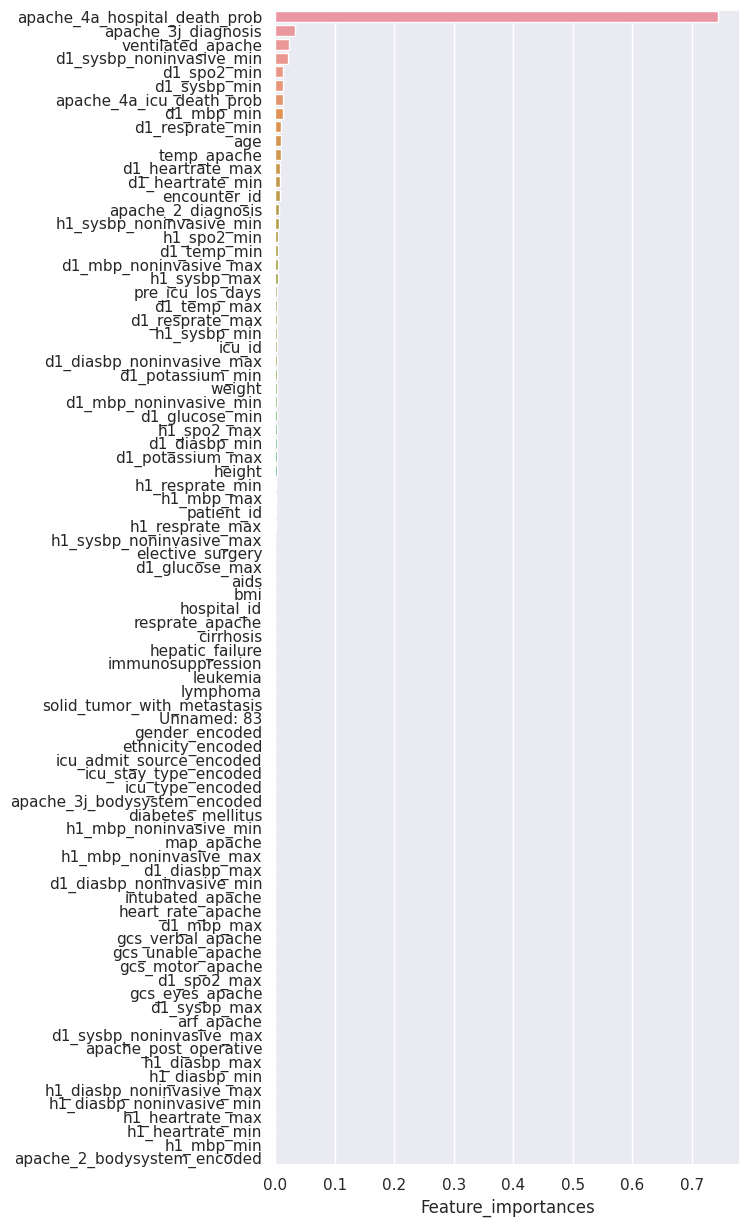

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 15))  # 그래프의 크기 조정 (가로, 세로)
sns.barplot(y=dft1.index, x="Feature_importances", data=dft1)

In [ ]:
# 데이터프레임 dft1의 막대그래프 그리기

#import seaborn as sns
#sns.barplot(y=dft1.index, x="Feature_importances", data=dft1);

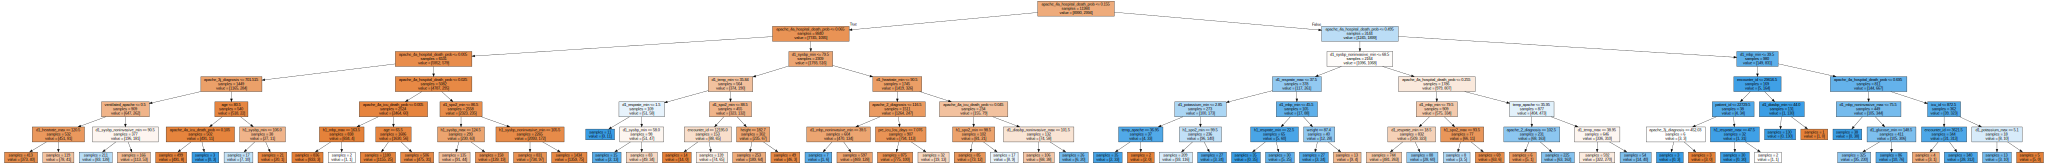

In [ ]:
# model의 결과물을 tree.dot에 저장
import graphviz
from sklearn.tree import export_graphviz
export_graphviz(best_clf, out_file = "tree.dot",
                feature_names = list(data.columns), impurity = False , filled = True )

# tree.dot을 graphviz 기능을 통해 디스플레이.
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 3. 로지스틱 회귀 모델 실행 및 성능평가

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = df.drop(['hospital_death'], axis=1)   # 타겟변수를 제외한 변수만 data에 저장
target = df['hospital_death']                # 타겟변수만 target에 저장

from imblearn.under_sampling import RandomUnderSampler    # RandomUnderSampler를 import
undersample = RandomUnderSampler(sampling_strategy=0.333, random_state=2)
                                                          # 타겟변수의 소수 클래스 및 다수 클래스를
                                                          # 1:3의 비율(=1/3)로 언더샘플링
data_under, target_under = undersample.fit_resample(data, target)
                                                          # data 및 target에 언더샘플링 적용


In [ ]:
# 50:50 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_under, target_under, test_size=0.5, random_state=42, stratify=target_under)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (11984, 84)
X_test shape: (11985, 84)


In [ ]:
# Logistic Regression 모형 (Default 모델)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression(solver='lbfgs',penalty='none',random_state=0,n_jobs=-1)
model = lr.fit(X_train, y_train)
pred = model.predict(X_test)

print ("Logreg Training set score:{:.5f}".format(model.score(X_train, y_train)))
print ("Logreg Test set score:{:.5f}".format(accuracy_score(y_test, pred)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Logreg Training set score:0.77754
Logreg Test set score:0.77322


In [ ]:
# Logistic Regression 모형 (Default 모델)
lr = LogisticRegression(solver='lbfgs',penalty='none',random_state=0,n_jobs=-1)

# 그리드 서치
from sklearn.model_selection import GridSearchCV
params = {'solver':['lbfgs', 'saga'], 'penalty':['none']}

grid_lr = GridSearchCV(lr, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1,)
grid_lr.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_lr.best_score_))
print("GridSearchCV best parameter:", (grid_lr.best_params_))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


GridSearchCV max accuracy:0.76744
GridSearchCV best parameter: {'penalty': 'none', 'solver': 'lbfgs'}


In [ ]:
#그리드 서치 최적 모델을 테스트 데이터세트에 적용한 결과
best_clf = grid_lr.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Accuracy on test set:0.77322


In [ ]:
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

ROC AUC on test set:0.73554


In [ ]:
# 변수명을 Index로 만들고 coefficient값을 매칭한 데이터프레임 만들기

feature_names = list(data.columns)   # 변수명(컬럼명)을 리스트 형태로 만들기
dft = pd.DataFrame(np.round(best_clf.coef_, 3).transpose(), index=feature_names,
                   columns=['coef'])
dft1 = dft.sort_values(by='coef', ascending=True)   # 컬럼 coef의 값들을 오름차순으로 정리
dft1

,coef
d1_sysbp_min,-0.007
d1_sysbp_noninvasive_min,-0.006
d1_mbp_noninvasive_min,-0.005
d1_mbp_min,-0.005
h1_sysbp_min,-0.004
...,...
h1_heartrate_min,0.003
h1_heartrate_max,0.004
age,0.005
heart_rate_apache,0.006


In [ ]:
# 변수명을 Index로 만들고 coefficient값을 제곱한 Odds ratio값을 Index에 매칭한 데이터프레임 만들기
#오즈비 계산

feature_names = list(data.columns)   # 변수명(컬럼명)을 리스트 형태로 만들기
dft = pd.DataFrame(np.round(np.exp(best_clf.coef_),3).transpose(), index=feature_names,
                   columns=['Odds_ratio'])
dft1 = dft.sort_values(by='Odds_ratio', ascending=False)   # 컬럼 coef의 값들을 내림차순으로 정리
dft1

,Odds_ratio
heart_rate_apache,1.006
d1_heartrate_max,1.006
age,1.005
h1_heartrate_max,1.004
h1_heartrate_min,1.003
...,...
h1_sysbp_min,0.996
d1_mbp_min,0.995
d1_mbp_noninvasive_min,0.995
d1_sysbp_noninvasive_min,0.994


## 4. 데이터 표준화 및 로지스틱 회귀 재실행

In [ ]:
# 구간 변수들만 별도로 모아 데이터프레임 df_num을 만든다.
numeric_cols = [ 'age', 'bmi', 'height', 'weight', 'heart_rate_apache', 'temp_apache' ]
df_num = df[numeric_cols]

# StandardScaler( )로 데이터 스케일 표준화를 실행하고 결과를 데이터프레임으로 만든다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_num_standard = pd.DataFrame(scaler.fit_transform(df_num))

# StandardScaler( )는 변수명을 지우므로, 새로 만든 데이터프레임에 다시 변수명을 넣는다.
df_num_standard.columns = df_num.columns
df_num_standard.head()

,age,bmi,height,weight,heart_rate_apache,temp_apache
0,0.338587,-0.569500,0.573150,-0.295037,0.608760,0.620106
1,-2.252764,0.373749,0.229303,0.460336,0.086957,0.226408
2,1.122019,-0.578707,-0.114543,-0.725670,0.478309,-0.061294
3,-2.614348,-2.894883,0.921521,-2.903545,-1.282778,0.226408
4,0.278323,-0.075369,1.034629,0.626235,0.445697,0.211266


In [ ]:
df_cat = df.drop(numeric_cols, axis=1) # 원래 데이터프레임 df에서 구간변수들을 제거하여 df_cat에 저장

In [ ]:
# 구간변수 스케일을 표준화한 df_num_standard와 범주형 변수만 담은 df_cat을 병합
dfu_standard = pd.concat([df_num_standard, df_cat], axis=1)
dfu_standard.columns   # dfu의 변수명을 나열

Index(['age', 'bmi', 'height', 'weight', 'heart_rate_apache', 'temp_apache',
       'encounter_id', 'patient_id', 'hospital_id', 'elective_surgery',
       'icu_id', 'pre_icu_los_days', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'intubated_apache', 'map_apache',
       'resprate_apache', 'ventilated_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
 

In [ ]:
dfu_standard.to_csv('/content/drive/MyDrive/Colab Notebooks/t/dataset-standard.csv', index=False)  # 병합한 데이터프레임을 csv 형태로 저장

In [ ]:
data = dfu_standard.drop(['hospital_death'], axis=1)   # 타겟변수를 제외한 변수만 data에 저장
target = dfu_standard['hospital_death']                # 타겟변수만 target에 저장

from imblearn.under_sampling import RandomUnderSampler    # RandomUnderSampler를 import
undersample = RandomUnderSampler(sampling_strategy=0.333, random_state=2)
                                                          # 타겟변수의 소수 클래스 및 다수 클래스를
                                                          # 1:3의 비율(=1/3)로 언더샘플링
data_under, target_under = undersample.fit_resample(data, target)
                                                          # data 및 target에 언더샘플링 적용

In [ ]:
# 50:50 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_under, target_under, test_size=0.5, random_state=42, stratify=target_under)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (11984, 84)
X_test shape: (11985, 84)


In [ ]:
# Logistic Regression 모형 (Default 모델)
lr = LogisticRegression(solver='lbfgs',penalty='none',random_state=0,n_jobs=-1)

# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV
params = {'solver':['lbfgs', 'saga'], 'penalty':['none']}

grid_lr = GridSearchCV(lr, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1,)
grid_lr.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_lr.best_score_))
print("GridSearchCV best parameter:", (grid_lr.best_params_))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


GridSearchCV max accuracy:0.76886
GridSearchCV best parameter: {'penalty': 'none', 'solver': 'lbfgs'}


In [ ]:
best_clf = grid_lr.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Accuracy on test set:0.76012


In [ ]:
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

ROC AUC on test set:0.71711


## 5. 범주형 변수 및 구간변수 오즈비 해석

In [ ]:
feature_names = list(data.columns)   # 변수명(컬럼명)을 리스트 형태로 만들기
dft = pd.DataFrame(np.round(np.exp(best_clf.coef_),3).transpose(), index=feature_names,
                   columns=['Odds_ratio'])
dft1 = dft.sort_values(by='Odds_ratio', ascending=False)   # 컬럼 coef의 값들을 내림차순으로 정리
dft1

,Odds_ratio
d1_heartrate_max,1.005
h1_heartrate_max,1.004
d1_glucose_max,1.003
h1_heartrate_min,1.003
d1_resprate_max,1.002
...,...
h1_sysbp_min,0.997
d1_mbp_noninvasive_min,0.996
d1_mbp_min,0.996
d1_sysbp_min,0.995


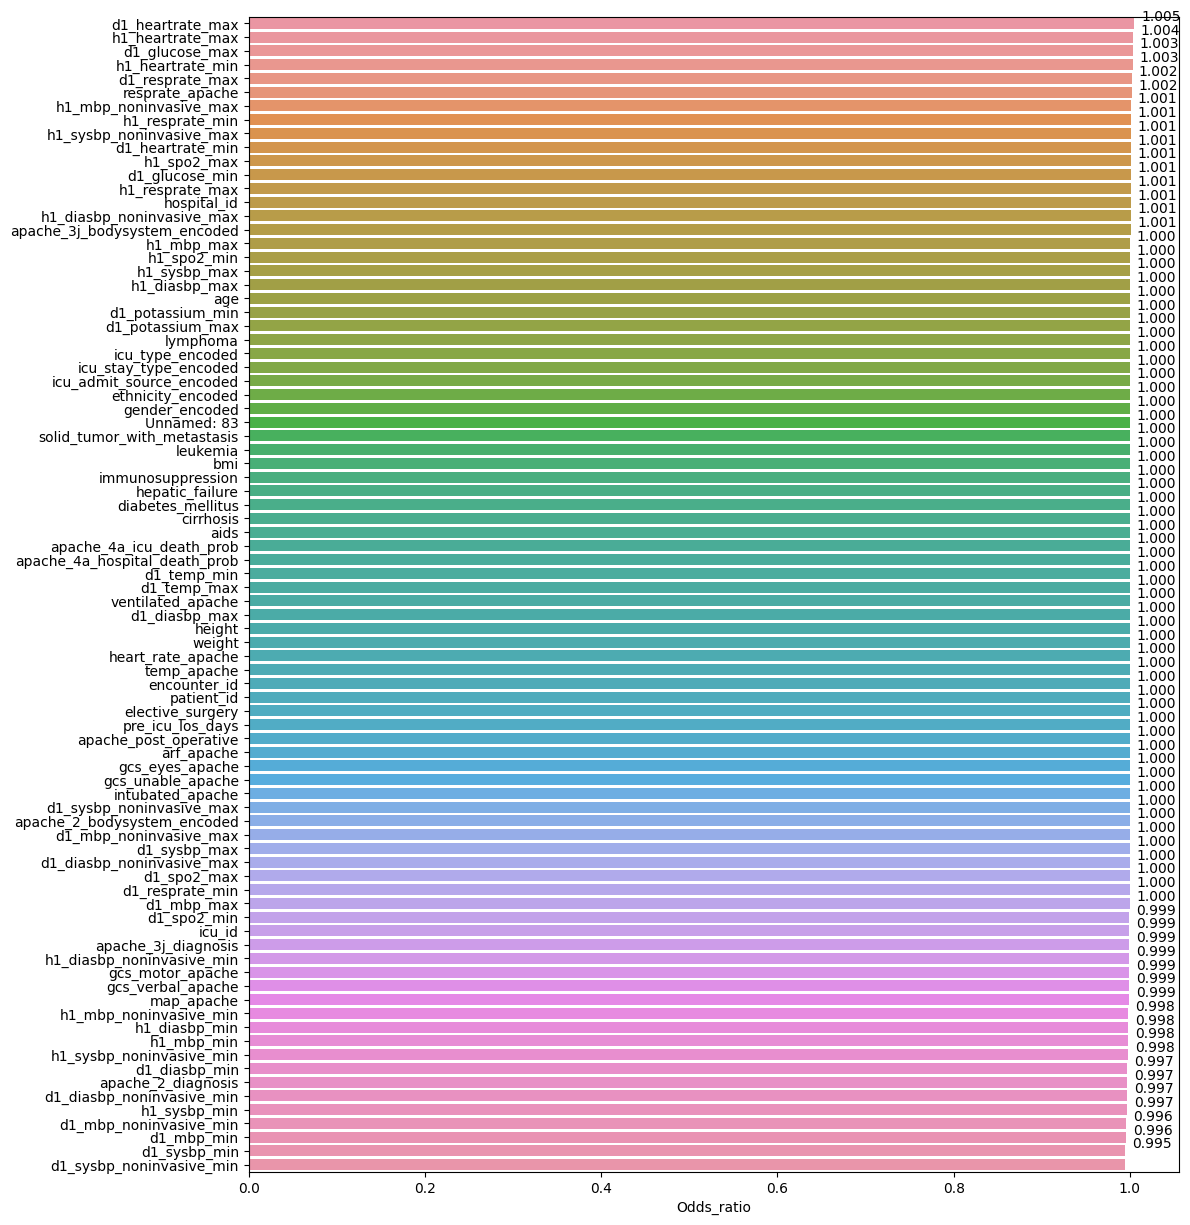

In [ ]:
# 데이터프레임 dft1의 막대그래프(barplot) 그리기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 그래프 크기 조정
plt.figure(figsize=(12, 15))
ax = sns.barplot(y=dft1.index, x="Odds_ratio", data=dft1)

for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()+1.2),
                xytext=(5, 10), textcoords='offset points')

## 6. 신경망 모델 실행 및 성능평가

In [ ]:
data = df.drop(['hospital_death'], axis=1)   # 타겟변수를 제외한 변수만 data에 저장
target = df['hospital_death']                # 타겟변수만 target에 저장

from imblearn.under_sampling import RandomUnderSampler    # RandomUnderSampler를 import
undersample = RandomUnderSampler(sampling_strategy=0.333, random_state=2)
                                                          # 타겟변수의 소수 클래스 및 다수 클래스를
                                                          # 1:3의 비율(=1/3)로 언더샘플링
data_under, target_under = undersample.fit_resample(data, target)
                                                          # data 및 target에 언더샘플링 적용

In [ ]:
# 50:50 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_under, target_under, test_size=0.5, random_state=42, stratify=target_under)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (11984, 84)
X_test shape: (11985, 84)


In [ ]:
# Neural Network 모델 (Default 모델 with adam solver)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
clf_mlp = MLPClassifier(max_iter = 2000, random_state = 0)
                       # convergence warinng을 회피하기 위해 max_iter = 2000으로 올려서 설정
clf_mlp.fit(X_train, y_train)
pred = clf_mlp.predict(X_test)  # 학습된 Classifier로 테스트 데이터셋 자료이용해서 타겟변수 예측값 생성
accuracy = accuracy_score(y_test, pred)

print ("Neural Network Training set score:{:.5f}".format(clf_mlp.score(X_train, y_train)))
print ("Neural Network Test set score:{:.5f}".format(accuracy_score(y_test, pred)))

Neural Network Training set score:0.77962
Neural Network Test set score:0.76504


In [ ]:
# 신경망 기본 모델 (with adam solver)
clf_mlp = MLPClassifier(max_iter = 20, random_state = 0)

# 그리드 서치 실행

from sklearn.model_selection import GridSearchCV
params = {'solver':['sgd', 'lbfgs', 'adam'],
          'alpha':[0.0001, 0.001, 0.01, 0.1, 1],
          'activation':['tanh','relu', 'logistic']
         }

grid_mlp = GridSearchCV(clf_mlp, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_mlp.best_score_))
print("GridSearchCV best parameter:", (grid_mlp.best_params_))

In [ ]:
best_clf = grid_mlp.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Accuracy on test set:0.00791


In [ ]:
# 그리드 서치 재실행
from sklearn.model_selection import GridSearchCV
params = {'solver':['sgd', 'lbfgs', 'adam'],
          'alpha':[0.0001, 0.01, 1],
          'activation':['tanh','relu', 'logistic'],
          'hidden_layer_sizes': [(100,), (100,100)]
         }

grid_mlp = GridSearchCV(clf_mlp, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_mlp.best_score_))
print("GridSearchCV best parameter:", (grid_mlp.best_params_))

In [ ]:
best_clf = grid_mlp.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

In [ ]:
from sklearn.metrics import roc_auc_score
ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

## 7. 랜덤 포레스트 모델 실행 및 성능평가

In [ ]:
# Random Forest 모델 (Default 모델, tree depth 제한 없음)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators = 100, random_state=0)
model = rf.fit(X_train, y_train)
pred = model.predict(X_test)  # 학습된 Classifier로 테스트 데이터셋 자료이용해서 타겟변수 예측값 생성
#accuracy = accuracy_score(y_test, pred)

print ("Random Forest Accuracy on training set:{:.5f}".format(model.score(X_train, y_train)))
print ("Random Forest Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

Random Forest Accuracy on training set:1.00000
Random Forest Accuracy on test set:0.83154


In [ ]:
# Random Forest 모델 (Default 모델, tree depth 제한 없음)
rf = RandomForestClassifier(n_estimators = 100, random_state=0)

# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# StratifiedKFold의 random_state 옵션값을 특정 숫자(예: 0)로 고정
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
params = {'max_depth': range(10, 41), 'n_estimators': [100, 200]}

# GridSearchCV의 cv=cross_validation 옵션값은 위의 StratifiedKFold의 random_state 옵션값을 적용시켜서
# GridSearchCV를 실행핼 때마다 결과가 항상 동일하게 나오도록 보장
grid_rf = GridSearchCV(rf, param_grid=params, scoring='accuracy', cv=cross_validation,
                       verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_rf.best_score_))
print("GridSearchCV best parameter:", (grid_rf.best_params_))

Fitting 5 folds for each of 62 candidates, totalling 310 fits


In [ ]:
best_clf = grid_rf.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))


Accuracy on test set:0.01186


In [ ]:
from sklearn.metrics import roc_auc_score

try:
   ROC_AUC = roc_auc_score(y_test,best_clf.predict_proba(X_test)[:, 1])
except ValueError:
    pass

print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

ROC AUC on test set:0.83065


In [ ]:
# 변수명을 Index로 만들고 feature_importances를 매칭해서 나열한 데이터프레임 만들기

feature_names = list(data.columns)   # 변수명(컬럼명)을 리스트 형태로 만들기
dft = pd.DataFrame(np.round(best_clf.feature_importances_, 3), index=feature_names,
                   columns=['Feature_importances'])
dft1 = dft.sort_values(by='Feature_importances', ascending=False)
dft1                                 # 컬럼 Feature_importances의 값들을 내림차순으로 정리

,Feature_importances
size,0.285
lot_size,0.222
zip_code,0.210
baths,0.132
beds,0.111
lot_size_units_encoded,0.040
size_units_encoded,0.000


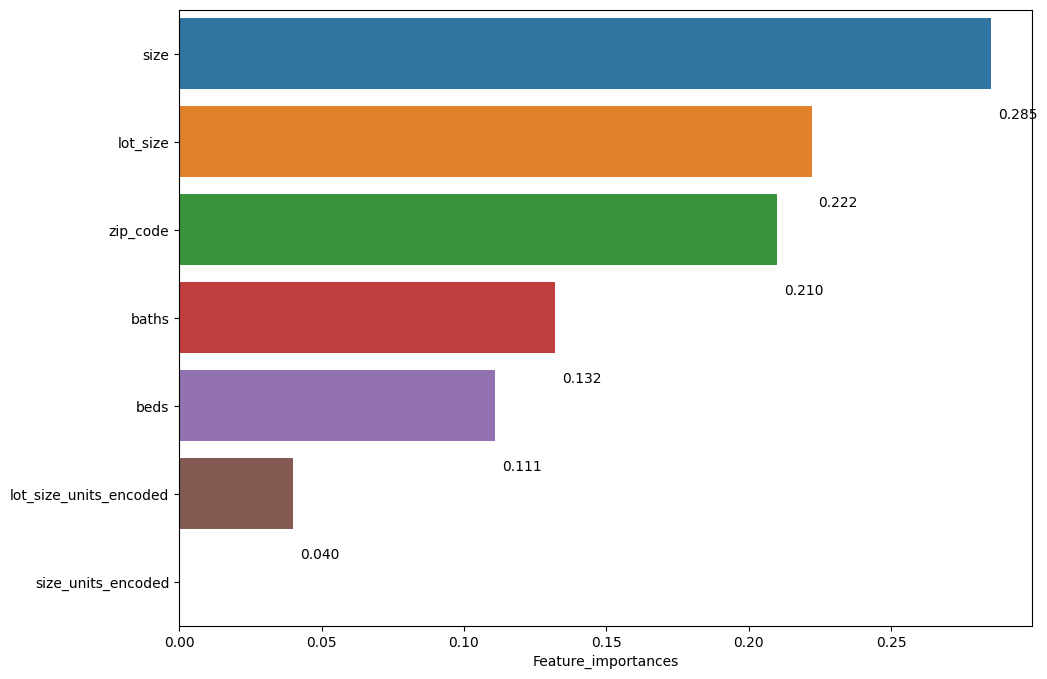

In [ ]:
# 데이터프레임 dft1의 막대그래프(barplot) 그리기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(11, 8))
ax = sns.barplot(y=dft1.index, x="Feature_importances", data=dft1)

for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()+1.3),
                xytext=(5, 10), textcoords='offset points')

### (이하 연속 변수 타겟변수에 적용)
## 1. 데이터 표준화

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/test.csv')

df.dtypes

beds                int64
baths             float64
size              float64
size_units         object
lot_size          float64
lot_size_units     object
zip_code            int64
price             float64
dtype: object

In [ ]:
from sklearn.preprocessing import OrdinalEncoder   # OrdinalEncoder를 import

# OrdinalEncoder를 사용하여 'gender' 열을 순서 인코딩
encoder = OrdinalEncoder()
df['size_units_encoded'] = encoder.fit_transform(df['size_units'].values.reshape(-1, 1))

# 무한대 값을 NaN으로 대체
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 -1로 대체
df['size_units_encoded'] = df['size_units_encoded'].fillna(-1)

# 'gender_encoded' 열의 데이터 타입을 int로 변환
df['size_units_encoded'] = df['size_units_encoded'].astype(int)
df.groupby(['size_units', 'size_units_encoded']).size()   # 변경전후 변수값 비교표 디스플레이

size_units  size_units_encoded
sqft        0                     505
dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder   # OrdinalEncoder를 import

# OrdinalEncoder를 사용하여 'gender' 열을 순서 인코딩
encoder = OrdinalEncoder()
df['lot_size_units_encoded'] = encoder.fit_transform(df['lot_size_units'].values.reshape(-1, 1))

# 무한대 값을 NaN으로 대체
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 -1로 대체
df['lot_size_units_encoded'] = df['lot_size_units_encoded'].fillna(-1)

# 'gender_encoded' 열의 데이터 타입을 int로 변환
df['lot_size_units_encoded'] = df['lot_size_units_encoded'].astype(int)
df.groupby(['lot_size_units', 'lot_size_units_encoded']).size()   # 변경전후 변수값 비교표 디스플레이

lot_size_units  lot_size_units_encoded
acre            0                          59
sqft            1                         369
dtype: int64

In [ ]:
df.drop(['lot_size_units','size_units'],axis=1, inplace=True)

In [ ]:
df.isna().any()[lambda x: x]

lot_size    True
dtype: bool

In [ ]:
import pandas as pd
import numpy as np

# NaN 값을 0으로 대체 (또는 다른 값으로 대체 가능)
df = df.fillna(0)

# 변수 타입 변환 (숫자로 변환 가능한 값만 변환)
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/archive/test-1.csv', index=False)

In [ ]:
# 구간 변수들만 별도로 모아 데이터프레임 df_num을 만든다.
numeric_cols = ['beds','baths', 'size', 'lot_size', 'zip_code', 'price']
df_num = df[numeric_cols]

# StandardScaler( )로 데이터 스케일 표준화를 실행하고 결과를 데이터프레임으로 만든다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_num_standard = pd.DataFrame(scaler.fit_transform(df_num))

# StandardScaler( )는 변수명을 지우므로, 새로 만든 데이터프레임에 다시 변수명을 넣는다.
df_num_standard.columns = df_num.columns
df_num_standard.head()

,beds,baths,size,lot_size,zip_code,price
0,0.037524,0.770642,1.083019,0.284260,-0.256186,0.321478
1,0.861421,2.746145,1.289173,0.564125,-0.779316,0.128181
2,0.037524,-1.204861,-0.609611,0.929136,-0.014742,-0.297072
3,0.037524,-0.217110,0.551360,-1.181268,2.520427,-0.682021
4,0.037524,1.264518,0.097822,-0.621985,-0.739076,0.341219


## 2. 회귀 모델 및 릿지 모델

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = df.drop(['price'], axis=1)   # 타겟변수(VALP임에 주의)를 제외한 입력변수를 data에 저장
target = df['price']                # 타겟변수만 target에 저장

# 50:50 data partition.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.5, random_state=42)   # test_size=0.5임에 주의

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (252, 7)
X_test shape: (253, 7)


In [ ]:
# 연속변수 타겟변수일 때 Linear Regression 모델 (Default 모델)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linr = LinearRegression(n_jobs=-1)
model = linr.fit(X_train, y_train)
pred = model.predict(X_test)

print ("Linear Regression Training set r2 score:{:.5f}".format(model.score(X_train, y_train)))
print ("Linear Regression Test set r2 score:{:.5f}".format(r2_score(y_test, pred)))

Linear Regression Training set r2 score:0.55626
Linear Regression Test set r2 score:0.50032


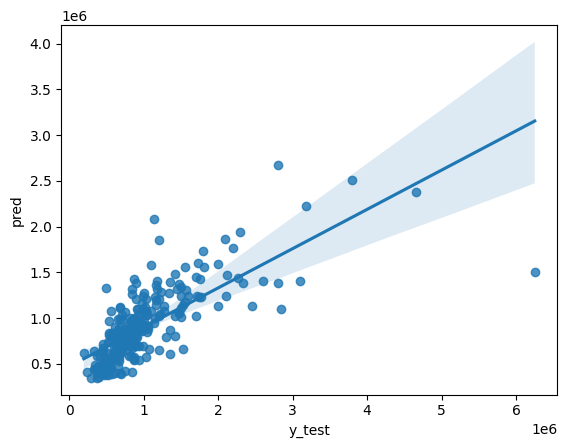

In [ ]:
import seaborn as sns

final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(pred)], axis = 1)
final_result.columns = ['y_test','pred']
sns.regplot(x = 'y_test', y = 'pred', data = final_result);

In [ ]:
# 연속변수 타겟변수일 때 Ridge 모델 (Default 모델).
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
Ridge = Ridge()
model = Ridge.fit(X_train, y_train)
pred = model.predict(X_test)  # 학습된 Classifier로 테스트 데이터셋 자료이용해서 타겟변수 예측값 생성.

print ("Linear Regression Training set score:{:.5f}".format(model.score(X_train, y_train)))
print ("Linear Regression Test set score:{:.5f}".format(r2_score(y_test, pred)))

Linear Regression Training set score:0.55626
Linear Regression Test set score:0.50040


In [ ]:
# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV

params = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'solver':['auto', 'svd', 'lsqr', 'cholesky','sparse_cg','sag','saga','lbfgs']}

grid_Ridge = GridSearchCV(Ridge, param_grid=params, scoring='r2', cv=5,\
                       n_jobs=-1, verbose=1)
grid_Ridge.fit(X_train, y_train)

print("GridSearchCV max score:{:.5f}".format(grid_Ridge.best_score_))
print("GridSearchCV best parameter:", (grid_Ridge.best_params_))

Fitting 5 folds for each of 56 candidates, totalling 280 fits
GridSearchCV max score:0.52061
GridSearchCV best parameter: {'alpha': 100, 'solver': 'auto'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 1134, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 825, in fit
    raise ValueError(
ValueError: 'lbfgs' solver can be used

In [ ]:
best_clf = grid_Ridge.best_estimator_
pred = best_clf.predict(X_test)

print("R2 Score on test set:{:.5f}".format(best_clf.score(X_test, y_test)))

R2 Score on test set:0.50000


## 3. XGBoost, LightGBM 모델 실행 및 성능평가

In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


3.1 XGBoost

In [ ]:
#XGBoost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/test-1.csv')
                              # 연속변수 타겟 VALP를 가지고 스케일 조정이 되지 않은 데이터셋인 house-unscaled-VALP.csv 불러오기
df.shape

(505, 8)

In [ ]:
df.head(3)

,beds,baths,size,lot_size,zip_code,price,size_units_encoded,lot_size_units_encoded
0,3,3.0,2850.0,4200.0,98119,1175000.0,0,1
1,4,5.0,3040.0,5002.0,98106,1057500.0,0,1
2,3,1.0,1290.0,6048.0,98125,799000.0,0,1


In [ ]:
data = df.drop(['price'], axis=1)   # 타겟변수(VALP임에 주의)를 제외한 입력변수를 data에 저장
target = df['price']                # 타겟변수만 target에 저장

# 50:50 데이터 변환
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.5, random_state=42)   # test_size=0.5임에 주의

In [ ]:
# 기본 XGBRegressor 모델
from sklearn.metrics import r2_score

xgb = XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))


r2: 0.46071


In [ ]:
# 그리드 서치 실행
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()

parameters = {'colsample_bytree': [0.7],
              'learning_rate': [0.05],
              'max_depth': [16],
              'min_child_weight' : [4],
              'n_estimators': [1000],
              'subsample': [0.8, 0.9]
              }

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        scoring = 'r2',
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [16], 'min_child_weight': [4],
                         'n_estimators': [1000], 'subsample': [0.8, 0.9]},
             scoring='r2', verbose=True)

In [ ]:
print('GridSearchCV 최적 파라미터:', xgb_grid.best_params_)

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 16, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 0.9}


In [ ]:
model = xgb_grid.best_estimator_
pred = model.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.46319


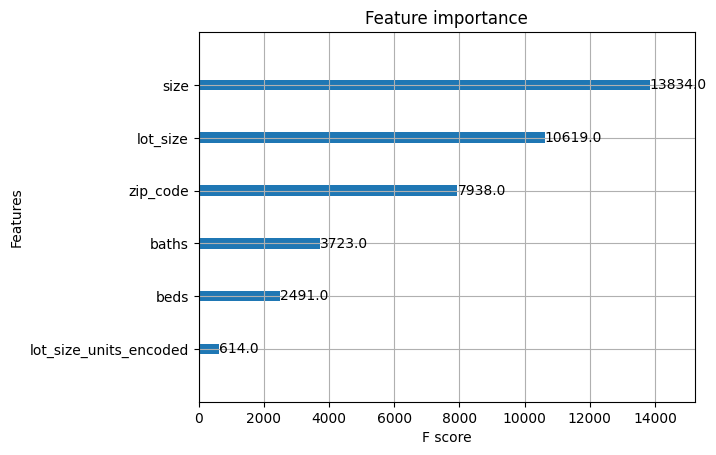

In [ ]:
from xgboost import plot_importance

plot_importance(model, max_num_features=10);

3.2 LightGBM

In [ ]:
# 기본 lGBMRegressor 모델
from ligㄴhtgbm import LGBMRegressor
from sklearn.metrics import r2_score

lgb = LGBMRegressor(random_state=0)
lgb.fit(X_train, y_train)
pred = lgb.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.47055


In [ ]:
#그리드 서치 실행
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

lgb = LGBMRegressor()

parameters = {'colsample_bytree': [0.7, 0.8],
              'learning_rate': [0.1, 0.15, 0.2],
              'max_depth': [11],
              'min_child_weight' : [4],
              'n_estimators': [1000],
              'subsample': [0.3, 0.4]
              }

lgb_grid = GridSearchCV(lgb,
                        parameters,
                        scoring = 'r2',
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)
lgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.15, 0.2], 'max_depth': [11],
                         'min_child_weight': [4], 'n_estimators': [1000],
                         'subsample': [0.3, 0.4]},
             scoring='r2', verbose=True)

In [ ]:
print('GridSearchCV 최적 파라미터:', lgb_grid.best_params_)

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 0.3}


In [ ]:
from sklearn.metrics import r2_score

model = lgb_grid.best_estimator_
pred = model.predict(X_test)

print('r2: {0:.5f}'.format(r2_score(y_test, pred)))

r2: 0.47630


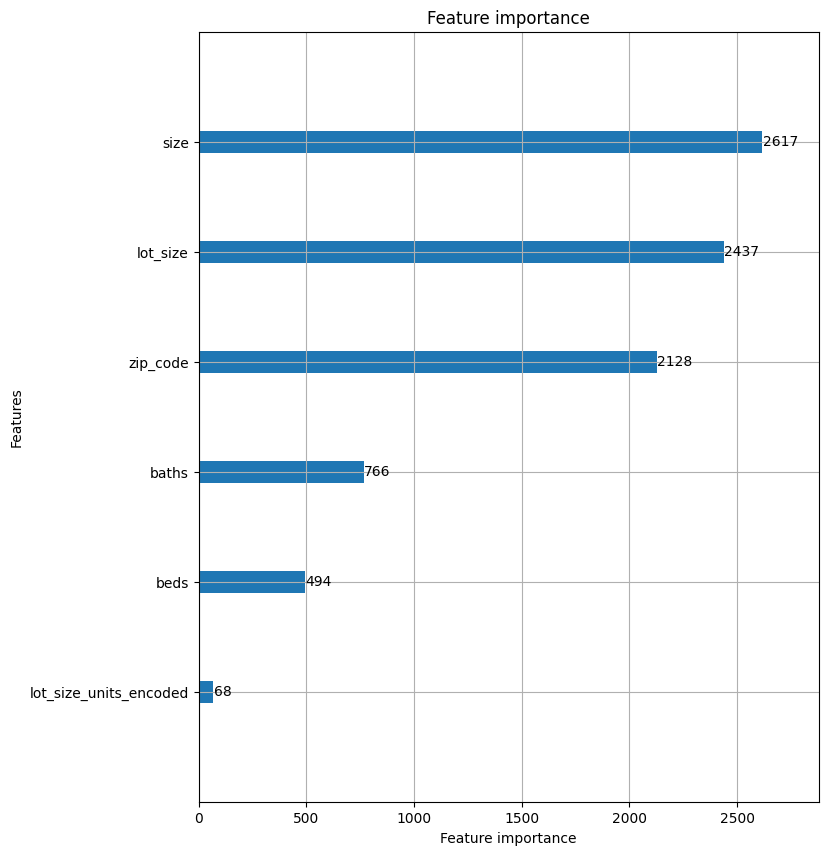

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 10))
plot_importance(model, ax=ax);